## **In this notebook two methods are presented to align IRIS images with ALMA images**
### Last edition: F.J Ordonez A,  7/01/2023
### e-mail: fjordoneza@unal.edu.co

In [1]:
from skimage.transform import rescale, AffineTransform, warp
from astropy.coordinates import EarthLocation,SkyCoord
from datetime import date, datetime,timedelta
import sunpy.visualization.colormaps as cm
from sunpy.net import Fido, attrs as SAF
from  scipy.stats.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
#from iris_lmsalpy import hcr2fits
import matplotlib.pyplot as plt
import scipy.ndimage as scnd
from astropy.io import fits
import astropy.units as u
from scipy import signal
import numpy as np
import sunpy.map
import matplotlib
import warnings
import salat
import glob
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

/tmp/ipykernel_70327/2371940998.py:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from  scipy.stats.stats import pearsonr


### The data worked on in this Notebook were taken from the SALSA database (ALMA Data [url: http://sdc.uio.no/salsa/] and manipulated with the library that bears the same name as the database, **D06 region  in SALSA database was aligned with IRIS**) . The IRIS data was taken from the IRIS database and its detailed libraries on its website https://iris.lmsal.com/

In [2]:
def aperture_circ_ALMA(alma_cube):
    """
    This function allow us to do a mask of a matrix with the FoV of ALMA

    Input  : almacube obtained using SALSA 
    Output : A matrix mask with the same shape to ALMA'S IMAGES 
    """
    x_size=alma_cube.shape[1]
    n = x_size
    #total size of the grid  in meters
    a = x_size
    aperture= np.zeros([n,n]) 
    #x grid 1D
    x = np.linspace(-a/2.0,a/2.0,n) 
    #y grid 1D
    y = np.linspace(-a/2.0,a/2.0,n)
    #radius of the telescope
    R = x_size/2 
    #making  circular aperture
    for j in range(0,n,1):
        for i in range(0,n,1):
            if ((x[i]**2.0 + y[j]**2.0)**(1/2) <= R):
                aperture[i,j] = 1.0
    return aperture

def fun_alma_rotate(cubo_alma, header_alma):
    """
    Regard to IRIS/SDO images the ALMA images are rotated. 
    This function delete this rotation and applied  the 
    function aperture_circ_ALMA to has the FoV of ALMA
    
    Input : ALMA CUBE taken from  SALSA
    Output: ALMA_CUBE without rotation  
    """
    #rotating ALMDA DATA
    imag_alma_rot=[]
    print('Rotating ALMA cube')
    for i in tqdm(range(len(cubo_alma)),colour='green'):
        imag_alma_rot.append(scnd.interpolation.rotate(cubo_alma[i],
                                                       angle=header_alma['SOLAR_P'],reshape=False))
    print('rotate angle',header_alma['SOLAR_P'])
    aperture=aperture_circ_ALMA(cubo_alma)
    imag_alma_rot                     = imag_alma_rot*aperture
    imag_alma_rot[imag_alma_rot<0.05] = cubo_alma[0][0][0] # cubo_alma[0][0][0] has mean value from ALMA cube
    return imag_alma_rot

In [4]:
path_ALMA='/media/javier/SSD_2/D06_region/datos_SDO-completos_IRIS_ALMA/ALMA_data/{}'
file=path_ALMA.format('D06_solaralma.b3.fba.20180412_155228-162441.2017.1.00653.S.level4.k.fits')
almacube, header, timesec, timeutc, beammajor, beamminor, beamangle = salat.read(file,timeout=True,beamout=True,
                                                                                 HEADER=True,SILENT=False,fillNan=True)


---------------------------------------------------
--------------- SALAT READ part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --

Reading ALMA cube



100%|██████████████████████████████████████| 1608/1608 [00:01<00:00, 874.42it/s]


Do you want to fill NaN with data median? (y/n): y
---------------------------------------------------
--------------- SALAT INFO part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --


----------------------------------------------
| Data feat.: 
----------------------------------------------
|  ALMA BAND:  3
|  Obs. Date:  2018-04-12
|  ALMA proj:  2017.1.00653.S
|  Pix. Unit:  K
|  Pix. Size:  0.3  arcsec.
|  Beam mean:  2.15798  arcsec
|  FOV. diam:  notcomputed
----------------------------------------------
| Data range 
----------------------------------------------
|  Min =  5260.81054688  Kelvin
|  Max =  10677.8203125  Kelvin
----------------------------------------------

Done!


## Reading IRIS FILE 

In [5]:
# Rotating ALMA cube
alma_rote=fun_alma_rotate(almacube,header)
# Reading IRIS FILE 
path='/media/javier/SSD_2/D06_region/datos_SDO-completos_IRIS_ALMA/IRIS_data/{}'
iris_2796=fits.open(path.format('iris_l2_20180412_130937_3640258010_SJI_2796_t000.fits'))
iris_1330=fits.open(path.format('iris_l2_20180412_130937_3640258010_SJI_1330_t000.fits'))
iris_1400=fits.open(path.format('iris_l2_20180412_130937_3640258010_SJI_1400_t000.fits'))
iris_2832=fits.open(path.format('iris_l2_20180412_130937_3640258010_SJI_2832_t000.fits'))

Rotating ALMA cube


100%|██████████████████████████████████████| 1608/1608 [00:11<00:00, 144.26it/s]


rotate angle -26.1446


In [5]:
iris_1330[0].data.shape, iris_1400[0].data.shape, iris_2796[0].data.shape,  iris_2832[0].data.shape

((950, 774, 735), (950, 774, 735), (950, 774, 735), (950, 774, 735))

In [14]:
prueba=sunpy.map.Map(iris_1330[0].data[0], iris_1330[0].header)
prueba.top_right_coord.Tx.value, prueba.top_right_coord.Ty.value
prueba.pixel_to_world(378.71956717763754*u.pix ,367.8990081154193*u.pix)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2018-04-12T13:09:37.920, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2018-04-12T13:09:37.920, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -5.81788249, 1.49967188e+11)>): (Tx, Ty) in arcsec
    (-116.33345115, -391.6330648)>

In [15]:
c = SkyCoord(Tx=-131.35079 * u.arcsec, Ty=-400.94382 *
             u.arcsec, frame=prueba.coordinate_frame)
c2 = SkyCoord(Tx=-117.55* u.arcsec,Ty=-392.819* u.arcsec,frame=prueba.coordinate_frame)
prueba.world_to_pixel(c2)

PixelPair(x=<Quantity 371.48724807 pix>, y=<Quantity 360.68787188 pix>)

In [16]:
prueba.world_to_pixel(c2).x.value*0.5545 ,prueba.world_to_pixel(c2).y.value*0.5545

(205.98967905218993, 200.00142495873888)

In [17]:
prueba.world_to_pixel(c).x.value*0.5545 ,prueba.world_to_pixel(c).y.value*0.5545

(160.2954928338347, 172.40183718033657)

Text(0.5, 1.0, 'ALMA  rotated')

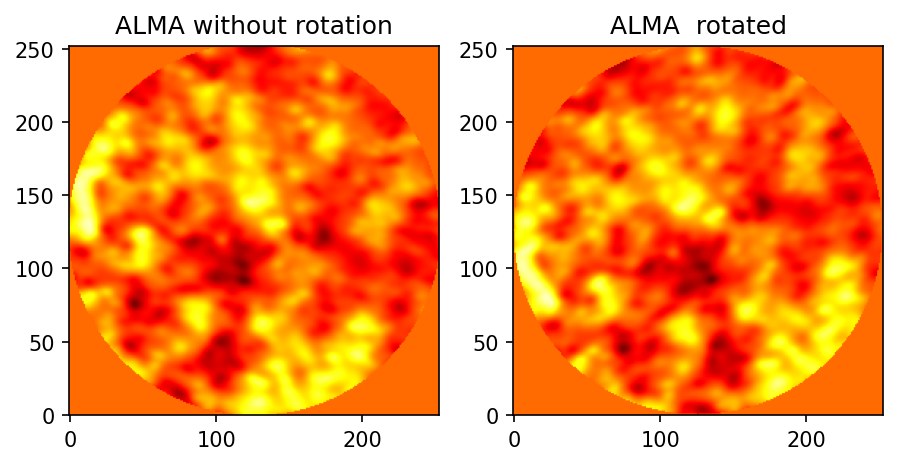

In [18]:
fig, ax=plt.subplots(ncols=2, nrows=1,dpi=150,figsize=(7,7))
ax[0].set_title('ALMA without rotation')
ax[0].imshow(almacube[0], cmap='hot', origin='lower', vmax=10000,vmin=5000)
ax[1].imshow(alma_rote[0], cmap='hot', origin='lower', vmax=10000,vmin=5000)
ax[1].set_title('ALMA  rotated')

In [6]:
def iris_rescale(iris_fits_file, alma_resolution):
    """
    This function rescale IRISeS images. For that,  
    we  taken  the IRIS'S images in its resolution 
    and we carry  to the ALMA resolution

    Input  :  IRIS FILE.FIT 
    Output :  Vector with IRIS IMAGES  rescaled 
    """
    # wearing  IRIS' resolution to ALMA resolution
    #|---- Band 3 ALMA resolution is 0.3 arcsec----|
    #|------- header['CDELT1A']=0.3 arcsec---------|
    print('______________________________________________________')
    print('initial shape:',iris_fits_file[0].data.shape)

    #alma_resolution=0.3 #|---- Band 3 ALMA resolution is 0.3 arcsec----|
    iris_resolution=iris_fits_file[0].header['CDELT1']
    scale_factor=iris_resolution/alma_resolution # to scale IRIS resolution
    print('scale_factor:', scale_factor)
    rescaling_iris=[]

    # from (950, 774, 735) ----> (950, 429, 408)
    #same resolution to IRIS-ALMA 0.3
    for i  in  tqdm(range(len(iris_fits_file[0].data)),colour='green' ):
        rescaling_iris.append(rescale(iris_fits_file[0].data[i], scale_factor, anti_aliasing=False,order=0,preserve_range=True))
    rescaling_iris=np.array(rescaling_iris) 
    print('______________________________________________________')
    print('final shape:',rescaling_iris.shape)
    
    return rescaling_iris

def creating_time_vector(iris_file):
    """
    This function allows us to create the time vector 
    in datetime.strptime format for IRIS data cubes.
    ----------------------------Input----------------------------------
    Parameters: 
                iris_file: type .fits  is the datacube of iris with its header 

    ----------------------------Output----------------------------------
    time vector type array and its elements  is  datetime.strptime format 
    """
    date_format   = "%Y-%m-%dT%H:%M:%S.%f"
    cadence       = iris_file[0].header['CADPL_AV']
    vec_sec_iris  = np.linspace(0,len(iris_file[0].data)-1,len(iris_file[0].data))*cadence 
    time_vec_iris = []
    for time_sec in vec_sec_iris:
        delta = timedelta(
        days=0,
        seconds=time_sec,
        microseconds=0,
        milliseconds=0,
        minutes=0,
        hours=0,
        weeks=0)
        time_vec_iris.append(delta+datetime.strptime(iris_file[0].header['STARTOBS'], date_format))
    return(np.array(time_vec_iris))

def find_nearest(array, alma_t0, alma_tf):
    '''
    This function allows us to find (in a time vector) 
    the initial and final times at times alma_t0, alma_tf.
    
    --------------------Input----------------------------------
    Parameters: 
                array : type array and its elements is in the datetime.datetime 
                        format (in this case we  obtained this vector using the )
                        in our case this time vector was obtained with the DATA-OBS 
                        of each previously downloaded SDO frame  
                alma_t0: type T0 is  where the ALMA observation has started
                         datetime.datetime  format
                alma_tf: type Tf is  where the ALMA observation has finalized 
                         datetime.datetime  format  
    --------------------Output----------------------------------
    Positions in the vector array (array) closest to the   alma_t0, alma_tf        
    '''
    array = np.asarray(array)
    idx_0 = (np.abs(array - alma_t0)).argmin()
    idx_f = (np.abs(array - alma_tf)).argmin()
    print('______________________________________________________')
    print('t_0_IRIS =', array[idx_0])
    print('t_0_ALMA=', alma_t0)
    print('______________________________________________________')
    print('t_f_IRIS =', array[idx_f])
    print('t_0_ALMA=', alma_tf)
    print('______________________________________________________')
    print('posicion_n_0:', idx_0, '| posicion_n_f:', idx_f)
    print('______________________________________________________')
    return idx_0, idx_f


In [27]:
def similarity(iris_fits_file, timeutc_alma, alma_cube):
    """
    This function aligns the IRIS and ALMA image. For that, it estimates the best Pearson 
    coefficient between the average matrix of the ALMA and IRIS data in the same observation 
    window and on the same scale (imsolating the images between a minimum (12th Percentile) 
    and a maximum (95th Percentile)). and for a given center, the ALMA image is transposed 
    onto the IRIS image in search of a maximum Pearson correlation.

    inpunt: -IRIS FILE
            -TIME UTC and ALMACUBE taken from  SALSA   
    Output: - x_max_pearson    : Position in the IRIS matrix that has the best x correlation 
            - y_max_pearson    : Position in the IRIS matrix that has the best y correlation 
            - int(posicion_n_0): Position in the IRIS datacube of image that was taken in the 
                                 t_0 ALMAUTC
            -int(posicion_n_f)   Position in the IRIS datacube of image that was taken in the 
                                 t_f ALMAUTC
    
    """
    #| wearing  IRIS' resolution to ALMA resolution
    #|---- Band 3 ALMA resolution is 0.3 arcsec----|
    #|------- header['CDELT1A']=0.3 arcsec---------|

    alma_resolution=0.3  #|---- Band 3 ALMA resolution is 0.3 arcsec----|
    iris_resolution=iris_fits_file[0].header['CDELT1']
    scale_factor=iris_resolution/alma_resolution # to scale IRIS resolution
    print('scale_factor:', scale_factor)
    rescaling_iris=[]

    # from (950, 774, 735) ----> (950, 429, 408)
    #same resolution to IRIS-ALMA 0.3
    print('ReScaling IRIS Image')
    for i  in tqdm(range(len(iris_fits_file[0].data)), colour='green'):
        rescaling_iris.append(rescale(iris_fits_file[0].data[i], scale_factor, anti_aliasing=False, order=0))
    rescaling_iris=np.array(rescaling_iris) 
    
    print('new IRIS VECTOR', rescaling_iris.shape)
    #print(np.max(rescaling_iris),np.min(rescaling_iris), np.std(rescaling_iris))
    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------
    
    #--------------Selecting the same windown of ALMA----------------

    time_vec_iris = creating_time_vector(iris_fits_file)

    posicion_n_0 , posicion_n_f  = find_nearest(time_vec_iris, timeutc_alma[0], timeutc_alma[-1])

    """
    cad_iris=iris_fits_file[0].header['CADEX_AV']
    date_format  = "%Y-%m-%dT%H:%M:%S.%f"
    t_0_OBS_iris = datetime.strptime(iris_fits_file[0].header['STARTOBS'], date_format)
    t_f_OBS_iris = datetime.strptime(iris_fits_file[0].header['ENDOBS']  , date_format)
    # Now we  want to know the fotogram in IRIS  that
    #was taken in the "same t0, t_f" of alma, for that:
    Δt_0         = timeutc_alma[0]-t_0_OBS_iris
    posicion_n_0 = Δt_0.total_seconds()/cad_iris

    # Now we want that  
    # t_0_OBS_iris+ n *  cad_iris = t_f_ALMA
    # SO, 
    # n= (t_f_ALMA  - t_0_OBS_iris )/cad_iris

    delta = timedelta(
        days=0,
        seconds=cad_iris*(posicion_n_0),
        microseconds=0,
        milliseconds=0,
        minutes=0,
        hours=0,
        weeks=0
    )    
    t_0=datetime.strptime(iris_fits_file[0].header['STARTOBS'], date_format)+delta
    Δt_f         = (timeutc_alma[-1]-t_0)
    posicion_n_f = Δt_f.total_seconds()/cad_iris
    posicion_n_f = round(posicion_n_f+posicion_n_0)
    """
    print('________________________________________________________________________')
    print('t_0 position in the IRIS array:',int(posicion_n_0),'| t_f position in the IRIS array:',int(posicion_n_f))
    #-----------------------------------------------------------------
    
    #-------------- Mean IRIS and ALMA datacube-----------------------
    mean_iris_iris = np.sum([i for i in rescaling_iris[int(posicion_n_0):int(posicion_n_f)]],0)/len(rescaling_iris[int(posicion_n_0):int(posicion_n_f)])
    mean_alma      = np.sum([i for i in alma_cube] , 0)/len(alma_cube)
    iris_interp    = np.interp(mean_iris_iris , (np.percentile(mean_iris_iris,12), np.percentile(mean_iris_iris,95)), (0,+1))
    alma_interp    = np.interp(mean_alma      , (np.percentile(mean_alma,11)     , np.percentile(mean_alma,95))     , (0,+1))
    #print(np.max(mean_iris_iris),np.max(mean_alma)),colour='green'
    #print(np.std(iris_interp)   ,np.std(alma_interp) )    

    #-------------- PEARSON ANALYSIS ---------------------------------    
    ccrr_pearson = np.zeros((iris_interp.shape[0],iris_interp.shape[1]))
    ccrr_ssim = np.zeros((iris_interp.shape[0], iris_interp.shape[1]))
    # ALMA_VECTOR
    flatten_alma=alma_interp.flatten()
    
    print('|----Estimating Pearson coeffients---- | ')
    for i in tqdm(range(0,iris_interp.shape[0]-255,1), position=0, desc="i", leave=False, colour='green', ncols=100):
        for j in range(0,iris_interp.shape[1]-255,1):
            matrix=iris_interp[0+i:253+i,0+j:253+j].copy()
            #matrix=matrix.flatten()
            corr, valor_p= pearsonr(matrix.flatten(), flatten_alma)
            ssim_none = ssim(matrix, alma_interp,
                             data_range=iris_interp.max() - iris_interp.min())

            x=i+alma_interp.shape[1]//2
            y=j+alma_interp.shape[0]//2

            ccrr_pearson[x][y]=corr
            ccrr_ssim[x][y] = ssim_none
    
    x_max_pearson = np.where(ccrr_pearson==np.max(ccrr_pearson))[1][0]
    y_max_pearson = np.where(ccrr_pearson==np.max(ccrr_pearson))[0][0]

    x_max_ssim = np.where(ccrr_ssim == np.max(ccrr_ssim))[1][0]
    y_max_ssim = np.where(ccrr_ssim == np.max(ccrr_ssim))[0][0]

    print('________________________________________________________________________')
    print('x_max_pearson=',x_max_pearson  , '| y_max_pearson=', y_max_pearson,"| r=",np.max(ccrr_pearson))
    
    print('________________________________________________________________________')
    print('x_max_ssim   =', x_max_ssim, '| y_max_ssim   =',
          y_max_ssim,   "| r=", np.max(ccrr_ssim))


    # Estimating  the helioprojective coordinates of x_max_pearson, y_max_pearson
    
    
    map_sunpy          = sunpy.map.Map(iris_fits_file[0].data[0], iris_fits_file[0].header)
    x_scaled_pearson, y_scaled_pearson =  x_max_pearson/scale_factor   ,  y_max_pearson/scale_factor
    cord_pearson               = map_sunpy.pixel_to_world(x_scaled_pearson*u.pix,  y_scaled_pearson*u.pix )

    x_scaled_ssim, y_scaled_ssim =  x_max_ssim/scale_factor   ,  y_max_ssim/scale_factor
    cord_ssim              = map_sunpy.pixel_to_world(x_scaled_ssim*u.pix,  y_scaled_ssim*u.pix )

    print('________________________________________________________________________')
    print('|-----Helioprojective coordinates-----|')
    print('New center Pearson :(x,y) in arcsec:', cord_pearson.Tx.value, cord_pearson.Ty.value)

    print('________________________________________________________________________')
    print('|-----Helioprojective coordinates-----|')
    print('New center SSIM : (x,y) in arcsec:', cord_ssim.Tx.value, cord_ssim.Ty.value)

    '''
    x_pixel = iris_fits_file[0].header['CRPIX1']* scale_factor
    y_pixel = iris_fits_file[0].header['CRPIX2']* scale_factor
    x_cord  = iris_fits_file[0].header['CRVAL1']
    y_cord  = iris_fits_file[0].header['CRVAL2']
    print('New center (x,y):',x_cord+(x_max_pearson-x_pixel)*iris_resolution, 
          y_cord+(y_max_pearson-y_pixel)*iris_resolution)
    '''

    
    return  x_max_pearson, y_max_pearson, int(posicion_n_0), int(posicion_n_f)


In [28]:
x_max_pearson_1330, x_max_pearson_1330, IRIS_1330_n_0, IRIS_1330_n_f = similarity(iris_1330, timeutc, alma_rote)

scale_factor: 0.5545
ReScaling IRIS Image


100%|██████████| 950/950 [00:02<00:00, 341.65it/s]


new IRIS VECTOR (950, 429, 408)
______________________________________________________
t_0_IRIS = 2018-04-12 15:52:18.956000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_IRIS = 2018-04-12 16:24:43.844000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 266 | posicion_n_f: 319
______________________________________________________
________________________________________________________________________
t_0 position in the IRIS array: 266 | t_f position in the IRIS array: 319
|----Estimating Pearson coeffients---- | 


                                                                                                    1.73s/it]

________________________________________________________________________
x_max_pearson= 206 | y_max_pearson= 200 | r= 0.7212863273322236
________________________________________________________________________
x_max_ssim   = 206 | y_max_ssim   = 201 | r= 0.2559658957333152
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center Pearson :(x,y) in arcsec: -117.54690871946514 -392.8194623691688
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center SSIM : (x,y) in arcsec: -117.54352648672648 -392.519480751337


: 

In [17]:
x_max_pearson_1400, x_max_pearson_1400, IRIS_1400_n_0, IRIS_1400_n_f =  similarity(iris_1400 , timeutc, alma_rote)

scale_factor: 0.5545
ReScaling IRIS Image


100%|██████████| 950/950 [00:02<00:00, 338.57it/s]


new IRIS VECTOR (950, 429, 408)
________________________________________________________________________
t_0 position in the IRIS array: 266 | t_f position in the IRIS array: 319
|----Estimating Pearson coeffients---- | 


                                                                                                    1.78s/it]

________________________________________________________________________
x_max_pearson= 207 | y_max_pearson= 201 | r= 0.5553238442864546
________________________________________________________________________
x_max_ssim   = 207 | y_max_ssim   = 201 | r= 0.14394634947041193
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center Pearson :(x,y) in arcsec: -117.1775477367919 -392.53186387379714
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center SSIM : (x,y) in arcsec: -117.1775477367919 -392.53186387379714


In [18]:
x_max_pearson_2832, x_max_pearson_2832, IRIS_2832_n_0, IRIS_2832_n_f =  similarity(iris_2832, timeutc, alma_rote)

scale_factor: 0.5545
ReScaling IRIS Image


100%|██████████| 950/950 [00:02<00:00, 352.74it/s]


new IRIS VECTOR (950, 429, 408)
________________________________________________________________________
t_0 position in the IRIS array: 266 | t_f position in the IRIS array: 319
|----Estimating Pearson coeffients---- | 


                                                                                                    1.62s/it]

________________________________________________________________________
x_max_pearson= 209 | y_max_pearson= 201 | r= 0.08191651241290618
________________________________________________________________________
x_max_ssim   = 262 | y_max_ssim   = 249 | r= 0.02721794569278765
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center Pearson :(x,y) in arcsec: -116.58058363385499 -392.5416289264128
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center SSIM : (x,y) in arcsec: -100.51917108590715 -378.32178245733803


In [19]:
x_max_pearson_2796, x_max_pearson_2796, IRIS_2796_n_0, IRIS_2796_n_f = similarity(iris_2796, timeutc, alma_rote)

scale_factor: 0.5545
ReScaling IRIS Image


100%|██████████| 950/950 [00:02<00:00, 364.84it/s]


new IRIS VECTOR (950, 429, 408)
________________________________________________________________________
t_0 position in the IRIS array: 266 | t_f position in the IRIS array: 319
|----Estimating Pearson coeffients---- | 


                                                                                                    1.65s/it]

________________________________________________________________________
x_max_pearson= 208 | y_max_pearson= 204 | r= 0.5189137069365268
________________________________________________________________________
x_max_ssim   = 208 | y_max_ssim   = 205 | r= 0.1453522901518624
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center Pearson :(x,y) in arcsec: -116.86641645454802 -391.63530077753774
________________________________________________________________________
|-----Helioprojective coordinates-----|
New center SSIM : (x,y) in arcsec: -116.86303412821144 -391.335319159711


## NOTA: READ the below comment 
 **It is to importan remenber  that the header of the IRIS data describe a  helioproyectives cordinates for a snapshot (PHOTOGRAM) that  its time in utc is different to the time utc where ALMA began to take  date, for that the  previous |-----Helioprojective coordinates-----| is wrong**.Now we need get a reference pixel  to stimate the  helioproyectives cordinates assosieted  with x_max_pearson, y_max_pearson. In order to  get the reference pixel we gonna align  IRIS images with SDO images using the program called ''function_alinging_IRIS_SDO''  For this paricular case, we obtined  that the center pixel of IRIS images has   (Tx, Ty) in arcsec -133.61651031300426, -397.4176236454267 helioproyective cordinates 

To obtenied the cordinate assoceted with **x_max_pearson, y_max_pearson** using the referenced pixel we calculete

 \begin{align}
   Tx_{x\_max\_pearson}=& -133.6165103130042 + (x\_shape\_iris/2 -x\_max\_pearson)*0.3 = -132.42 arcsec \notag
   \\
   Ty_{x\_max\_pearson}=& -397.4176236454267 + (y\_max\_pearson-y\_shape\_iris/2)*0.3 = -401.77 arcsec \notag
 \end{align}
 where **x_shape_iris/2, y_shape_iris/2**  is obtained by taking the dimensions of the IRIS images scaled to the same ALMA resolution and dividing them by two

### Now, we going to do a cropping of IRIS data cube with ALMA FoV using the center (x_max pearson, y_max pearson) obtained through Pearson's method

### We going to plot the images of IRIS and ALMA taken in the same UTC time to compare our alingment 

In [7]:
a                   = 266    # Image in IRIS data cube that was taken in Roughly the same utctime that the First image in ALMA data Cube
b                   = 0      # First image in ALMA data Cube   

#a                   = 266+53  # Image in IRIS data cube that was taken in Roughly the same utctime that the last image in ALMA data Cube  
#b                   = -1      # last image in ALMA data Cube
cord_pix_iris_x     = 171.32599999999996
cord_pix_iris_y     = 176.62208333333336

rescaling_iris_2796 = iris_rescale(iris_2796,0.3)[a]
rescaling_iris_2832 = iris_rescale(iris_2832,0.3)[a]
rescaling_iris_1400 = iris_rescale(iris_1400,0.3)[a]
rescaling_iris_1330 = iris_rescale(iris_1330,0.3)[a]

______________________________________________________
initial shape: (950, 774, 735)
scale_factor: 0.5545


100%|████████████████████████████████████████| 950/950 [00:02<00:00, 404.86it/s]


______________________________________________________
final shape: (950, 429, 408)
______________________________________________________
initial shape: (950, 774, 735)
scale_factor: 0.5545


100%|████████████████████████████████████████| 950/950 [00:02<00:00, 329.30it/s]


______________________________________________________
final shape: (950, 429, 408)
______________________________________________________
initial shape: (950, 774, 735)
scale_factor: 0.5545


100%|████████████████████████████████████████| 950/950 [00:03<00:00, 253.85it/s]


______________________________________________________
final shape: (950, 429, 408)
______________________________________________________
initial shape: (950, 774, 735)
scale_factor: 0.5545


100%|████████████████████████████████████████| 950/950 [00:02<00:00, 417.31it/s]


______________________________________________________
final shape: (950, 429, 408)


### Plotting the center obtained through Pearson method

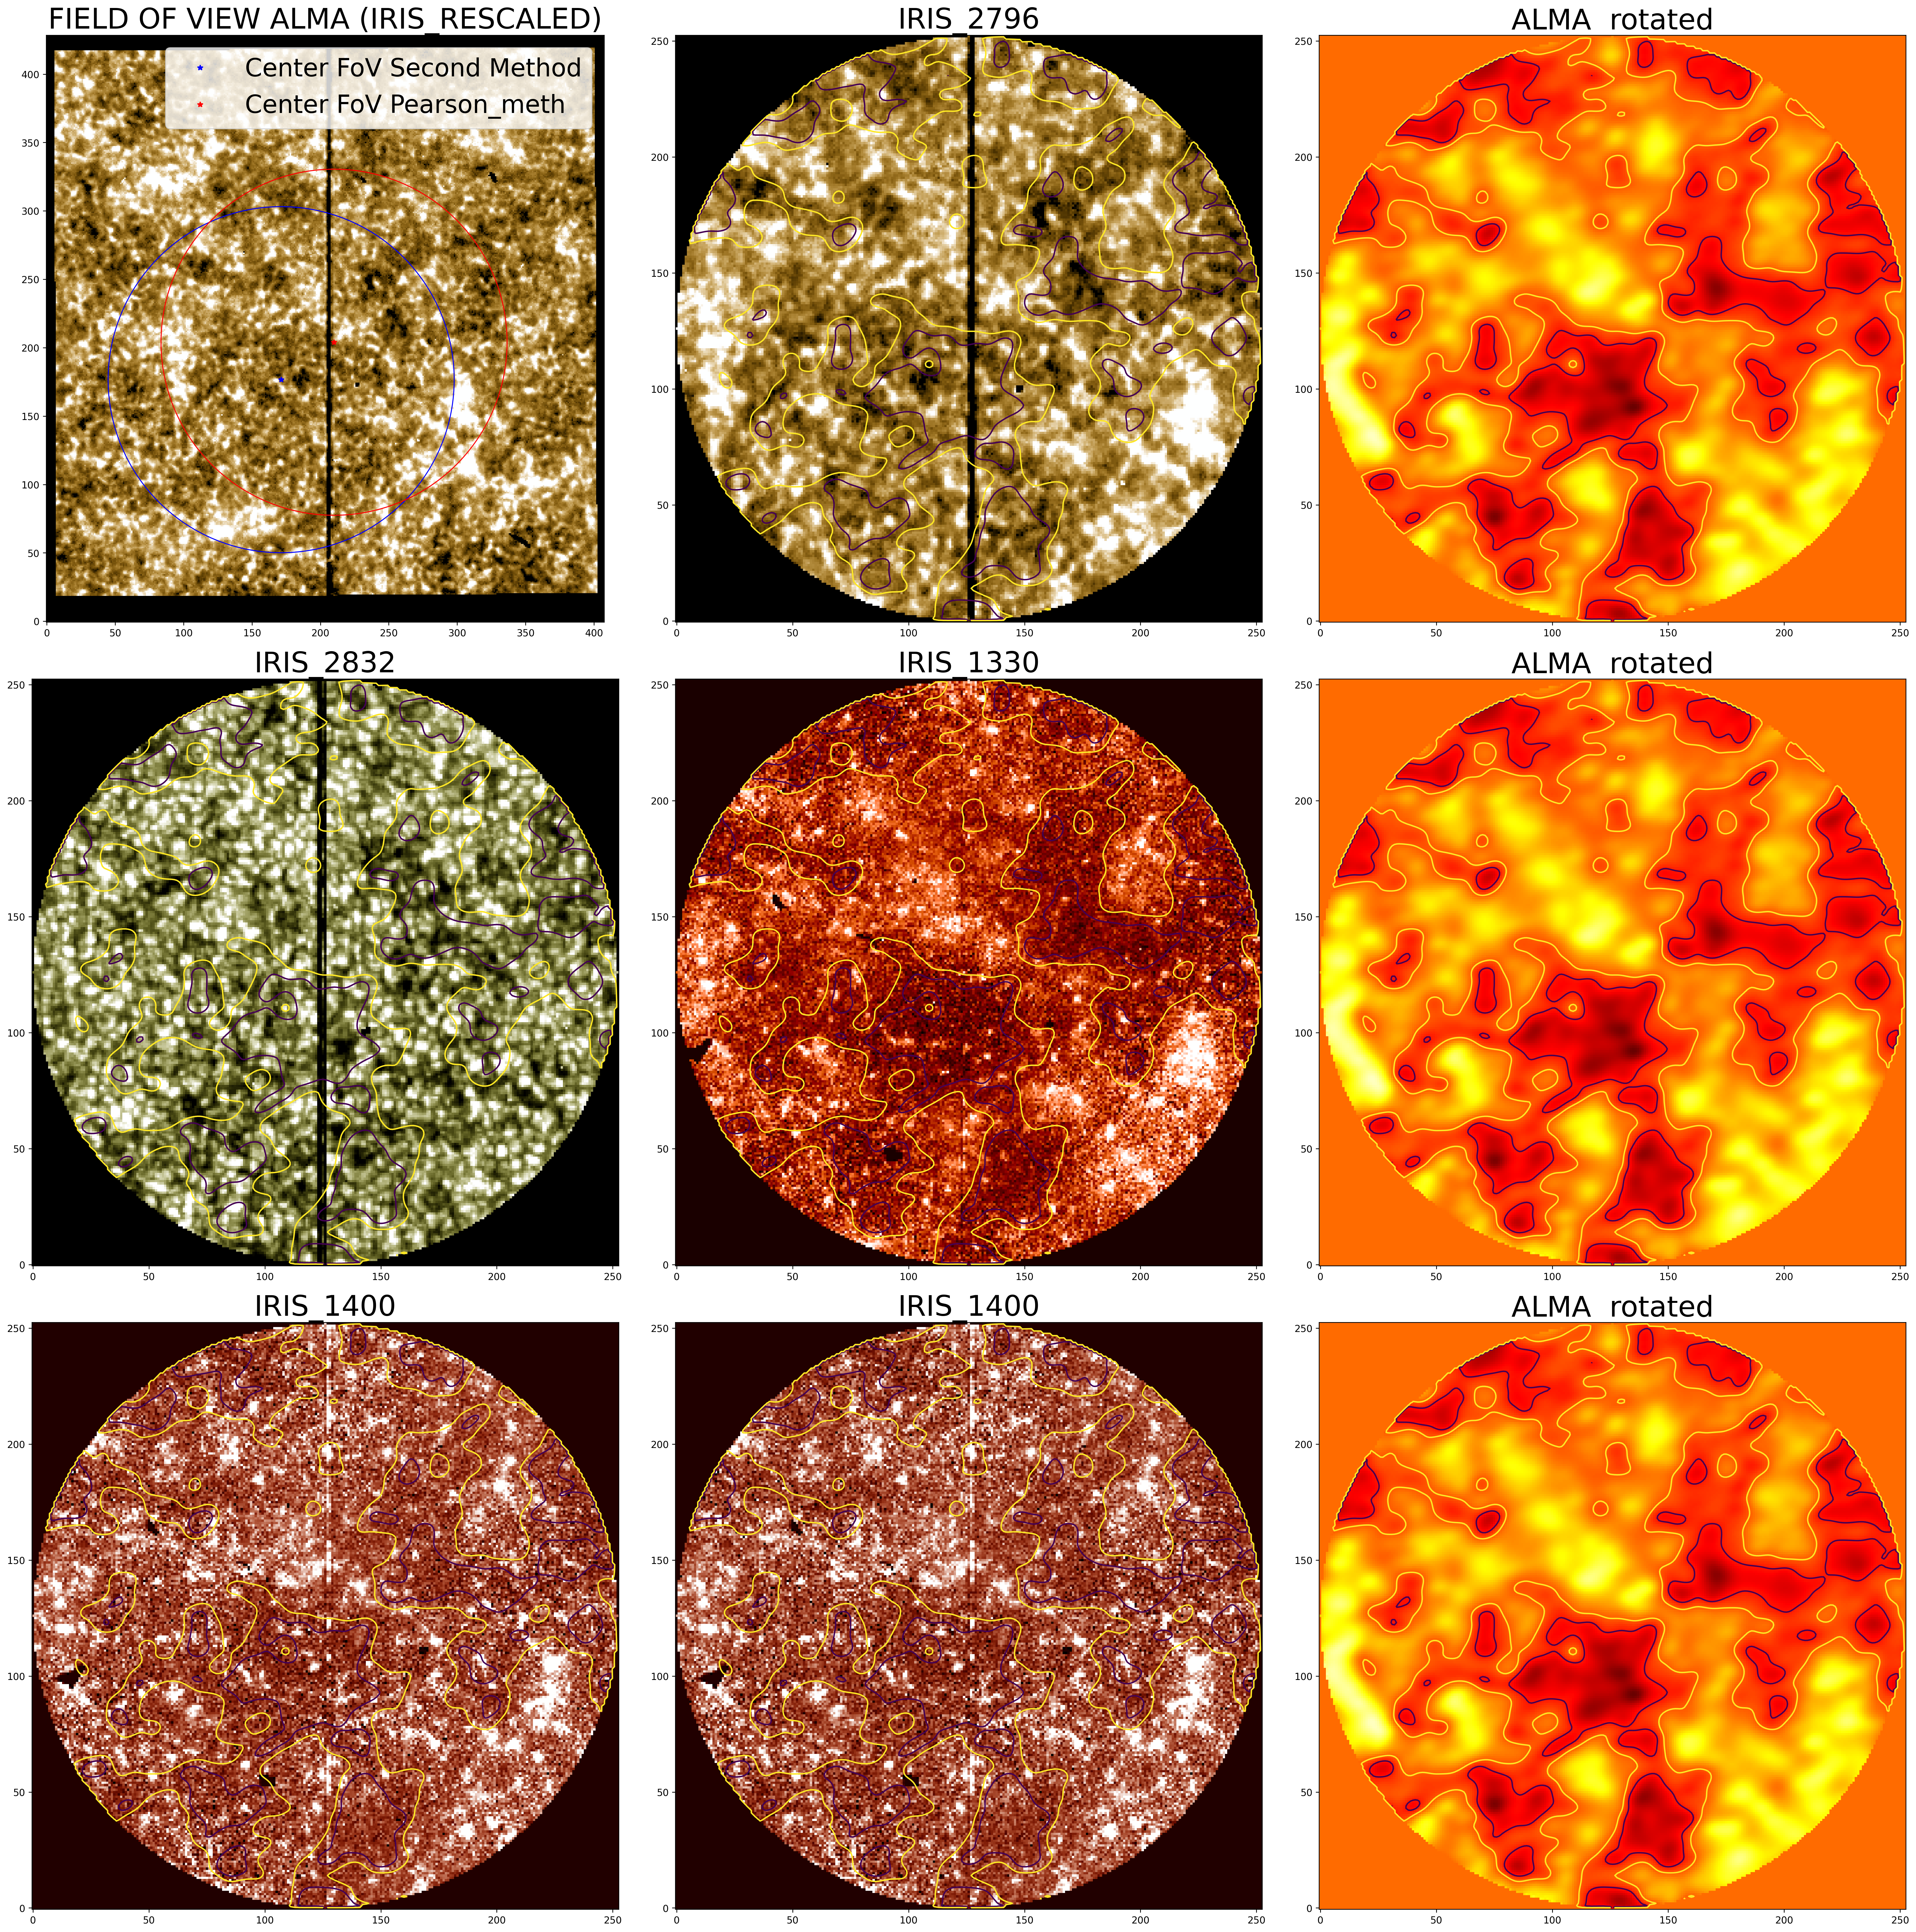

In [15]:
fig, ax=plt.subplots(figsize=(28,28), dpi=250, ncols=3, nrows=3,  constrained_layout=True)
aperture=aperture_circ_ALMA(almacube)


x_cen, y_cen  = iris_2796[0].data.shape[2]/2, iris_2796[0].data.shape[1]/2
x_ref, y_ref  = -133.6165103130042, -397.4176236454267

x_bottom_left = x_ref-(x_cen)*iris_2796[0].header['CDELT1']
x_top_right   = x_ref+(x_cen)*iris_2796[0].header['CDELT1']
y_bottom_left = y_ref-(y_cen)*iris_2796[0].header['CDELT1']
y_top_right   = y_ref+(y_cen)*iris_2796[0].header['CDELT1']
extent_iris   = [x_bottom_left,x_top_right, y_bottom_left, y_top_right]

x_max_person  = 206
y_max_person  = 200
## dict_keys([' 'sdoaia94', 'sdoaia131', 'sdoaia171', 'sdoaia193','sdoaia211', 'sdoaia304'
#  , 'sdoaia335', 'sdoaia1600', 'sdoaia1700', 'sdoaia4500','hmimag', 'irissji1330', 'irissji1400',  
#  'irissji1600', 'irissji2796', 'irissji2832', 'irissji5000', 'irissjiFUV', 'irissjiNUV', 'irissjiSJI_NUV',

y_new_i=int(y_max_person-253/2)
y_new_f=int(y_max_person+253/2)
x_new_i=int(x_max_person-253/2)
x_new_f=int(x_max_person+253/2)

vmin_2796 = np.percentile(rescaling_iris_2796,11) 
vmax_2796 = np.percentile(rescaling_iris_2796,95) 

vmin_2832 = np.percentile(rescaling_iris_2832,11) 
vmax_2832 = np.percentile(rescaling_iris_2832,95) 

vmin_1400 = np.percentile(rescaling_iris_1400,12) 
vmax_1400 = np.percentile(rescaling_iris_1400,95) 

vmin_1330 = np.percentile(rescaling_iris_1330,12) 
vmax_1330 = np.percentile(rescaling_iris_1330,98) 
#vmin = 0
#vmax = 150

plt.subplots_adjust(wspace=0.0,hspace=0.0)

ax[0,0].set_title('FIELD OF VIEW ALMA (IRIS_RESCALED)',fontsize = 30)
ax[0,0].imshow(rescaling_iris_2796,origin='lower',cmap='irissji2796',
               vmin=vmin_2796 , vmax=vmax_2796)
ax[0,0].plot( cord_pix_iris_x,  cord_pix_iris_y,'b*' , label='Center FoV Second Method')
curculo=matplotlib.patches.Circle((cord_pix_iris_x, cord_pix_iris_y,'b*'),253/2,ec='blue', fc='none')
ax[0,0].add_patch(curculo)
curculo_3=matplotlib.patches.Circle(( 210,204,'b*'),253/2,ec='red', fc='none')
ax[0,0].add_patch(curculo_3)
ax[0,0].plot(210, 204,'r*', label='Center FoV Pearson_meth')
ax[0,0].legend(prop={"size":26})



ax[0,1].set_title('IRIS_2796',fontsize = 30)
ax[0,1].imshow(rescaling_iris_2796[y_new_i:y_new_f, x_new_i:x_new_f]*aperture,origin='lower',cmap='irissji2796',
               vmin=vmin_2796 , vmax=vmax_2796)
ax[0,1].contour(alma_rote[b],levels=[7000,7500])

ax[0,2].imshow(alma_rote[b], cmap='hot', origin='lower', vmax=10000,vmin=5000)
ax[0,2].contour(alma_rote[b],levels=[7000,7500])
ax[0,2].set_title('ALMA  rotated',fontsize = 30)




ax[1,0].set_title('IRIS_2832',fontsize = 30)
ax[1,0].imshow(rescaling_iris_2832[y_new_i:y_new_f, x_new_i:x_new_f]*aperture,origin='lower',cmap='irissji2832',
               vmin=vmin_2832 , vmax=vmax_2832)
ax[1,0].contour(alma_rote[b],levels=[7000,7500])
ax[1,1].set_title('IRIS_1330',fontsize = 30)
ax[1,1].imshow(rescaling_iris_1330[y_new_i:y_new_f, x_new_i:x_new_f]*aperture,origin='lower',
               vmin=vmin_1330 , vmax=vmax_1330,cmap='irissji1330')
ax[1,1].contour(alma_rote[b],levels=[7000,7500])
ax[1,2].imshow(alma_rote[b], cmap='hot', origin='lower', vmax=10000,vmin=5000)
ax[1,2].contour(alma_rote[b],levels=[7000,7500])
ax[1,2].set_title('ALMA  rotated',fontsize = 30)


ax[2,0].set_title('IRIS_1400',fontsize = 30)
ax[2,0].imshow(rescaling_iris_1400[y_new_i:y_new_f, x_new_i:x_new_f]*aperture,origin='lower',
               vmin=vmin_1400 , vmax=vmax_1400 ,cmap='irissji1400' )
ax[2,0].contour(alma_rote[b],levels=[7000,7500])

ax[2,1].set_title('IRIS_1400',fontsize = 30)
ax[2,1].imshow(rescaling_iris_1400[y_new_i:y_new_f, x_new_i:x_new_f]*aperture,origin='lower',
               vmin=vmin_1400 , vmax=vmax_1400, cmap='irissji1400')

ax[2,1].contour(alma_rote[b],levels=[7000,7500])
ax[2,2].imshow(alma_rote[b], cmap='hot', origin='lower', vmax=10000,vmin=5000)
ax[2,2].contour(alma_rote[b],levels=[7000,7500])
ax[2,2].set_title('ALMA  rotated',fontsize = 30)
sub_title=fig.suptitle('Alignment of  ALMA with IRIS data, T_x ,T_y = -132.42, --397.4176 arcsec',fontsize = fontsize_word+20, y=1.02)

plt.savefig('IRIS_ALINEACION.png',dpi=200)
plt.show()

## ANOTHER METHOD TO ALIGN IRIS IMAGE WITH ALMA **("Second Method")**
## NOTA: READ the below comment 
**I don't recommend this method because assuming that the coordinate in the header is perfect is incorrect. Furthermore, the header of the IRIS data corresponds to a different UTC time than the UTC time in which ALMA started collecting data. Therefore, to associate the coordinates of the IRIS header with those of ALMA requires applying the differential rotation on said coordinates. This method was tried but the results were not good.**

**The following program is made assuming that the IRIS header provides coordinates for a UTC time equal to the UTC time at which ALMA started collecting data.
WHICH IS AN ERROR, the second method serves as a pedagogical tool where what should NOT be done when aligning the data is illustrated**

#------------------------Pedagogical Program----------------------------------

n_x: x translations necessary to align x IRIS center to x ALMA center 

n_y: y translations necessary to align y IRIS center to y ALMA center

$x_{IRIS}, y_{IRIS}, x_{ALMA}, y_{ALMA}$ are the  Helioprojective coordinates  of the centers IRIS and ALMA image



we want that:
\begin{align}
     x_{ALMA}=& 0.3*n_x+x_{IRIS}
    \\
    y_{ALMA}=&0.3*n_y+y_{IRIS} 
    \\
    \Rightarrow\hspace{0.1cm} n_x=&(x_{ALMA}-x_{IRIS})/0.3
    \\
 \Rightarrow\hspace{0.1cm}   n_y=&(y_{ALMA}-y_{IRIS})/0.3
\end{align}

0.3*n_x+x_IRIS= x_ALMA ------>n_x=(x_ALMA-x_IRIS)/0.3


0.3*n_y+y_{IRIS}= y_ALMA ------>n_y=(y_ALMA-y_IRIS)/0.3

thus, the deplacement  vector is

deltaX=[n_x,n_y]

We going to use the  "deltaX" vector to deplacement the center of coordinate of image, the center in pixels  **(NO the center of Helioprojective coordinates $x_{IRIS}, y_{IRIS}, x_{ALMA}, y_{ALMA}$ showed before)** with this we going to obtain the center of image aligned 


In [5]:
def image_alignment(alma_header, iris_data, cord_alma_center_x, cord_alma_center_y, aperture_matrix, time_utc_alma):
    '''
    Using this function we could do aling of image  of alma  and iris telescope
    
    alma_header       : header of alma
    iris_data         : iris file.fits (HDUList)
    cord_alma_center_x: x-coordinate helioproyective of alma 
    cord_alma_center_y: y-coordinate helioproyective of alma
    aperture_matrix   : matrix its shape (253,253)  and is the alma aperture
    '''
    alma_resolution=alma_header['CDELT1A ']
    iris_resolution=iris_data[0].header['CDELT1']
    scale_factor=iris_resolution/alma_resolution # to scale IRIS resolution
    print('scale_factor:', scale_factor)
    rescaling_iris=[]
    
    # from (950, 774, 735) ----> (950, 429, 408)
    #same resolution to IRIS-ALMA 0.3
    for i  in range(len(iris_data[0].data)):
        rescaling_iris.append(rescale(iris_data[0].data[i], scale_factor, anti_aliasing=False))
    rescaling_iris=np.array(rescaling_iris) 
    
    #new_center_of_pixel_IRIS
    cord_pix_iris_x=iris_data[0].header['CRPIX1']*scale_factor
    cord_pix_iris_y=iris_data[0].header['CRPIX2']*scale_factor
    #Cord center_of_pixel_IRIS
    cord_iris_center_x=iris_data[0].header['CRVAL1']
    cord_iris_center_y=iris_data[0].header['CRVAL2']
    print('%Diferencia Max=',np.abs((np.max(rescaling_iris)-np.max(iris_data[0].data)))/np.max(iris_data[0].data) *100)
    # center of ALMA data pixel
    
    #--------------Selecting the same windown of alma----------------
    cad_iris=iris_2796[0].header['CADEX_AV']
    date_format  = "%Y-%m-%dT%H:%M:%S.%f"
    t_0_OBS_iris = datetime.strptime(iris_2796[0].header['STARTOBS'], date_format)
    t_f_OBS_iris = datetime.strptime(iris_2796[0].header['ENDOBS'], date_format)
    # Now we  want to know the fotogram in IRIS  that
    #was taken in the "same t0, t_f" of alma, for that:
    Δt_0         = time_utc_alma[0]-t_0_OBS_iris
    posicion_n_0 = Δt_0.total_seconds()/cad_iris
    
    # Now we want that  
    # t_0_OBS_iris+ n *  cad_iris = t_f_ALMA
    # SO, 
    # n= (t_f_ALMA  - t_0_OBS_iris )/cad_iris
    
    delta = timedelta(
        days=0,
        seconds=cad_iris*(posicion_n_0),
        microseconds=0,
        milliseconds=0,
        minutes=0,
        hours=0,
        weeks=0
    )    
    t_0=datetime.strptime(iris_2796[0].header['STARTOBS'], date_format)+delta
    Δt_f         = (timeutc[-1]-t_0)
    posicion_n_f = Δt_f.total_seconds()/cad_iris
    posicion_n_f=round(posicion_n_f+posicion_n_0)
    
    print('t_0 position in the IRIS array:',int(posicion_n_0),'| t_f position in the IRIS array:',int(posicion_n_f))
    #-----------------------------------------------------------------
    
    
    cord_pix_alma_x=round(253/2)
    cord_pix_alma_y=round(253/2)

    #cord_pix_alma_x=alma_header['CRPIX1A'] # this values in the D06 data cube are wrong 
    #cord_pix_alma_y=alma_header['CRPIX2A'] # the pixel reference is 253/2, 253/2
    
    # center of ALMA data pixel
    cord_alma_center_x=-128
    cord_alma_center_y=-400 
    
    #Deplacement vector: [n_x,n_y]
    n_x=(cord_alma_center_x-cord_iris_center_x)/0.3
    n_y=(cord_alma_center_y-cord_iris_center_y)/0.3

    # new windowns of observation
    y_new_i=round(cord_pix_iris_y+n_y-253/2)
    y_new_f=round(cord_pix_iris_y+n_y+253/2)
    x_new_i=round(cord_pix_iris_x+n_x-253/2)
    x_new_f=round(cord_pix_iris_x+n_x+253/2)
    
    vector_iris_FoV_alma=[]
    #cropping images and appling  FoV of ALMA 
    for i  in range(int(posicion_n_0),int(posicion_n_f),1):
        vector_iris_FoV_alma.append(rescaling_iris[i][y_new_i:y_new_f, x_new_i:x_new_f]*aperture_matrix)
    vector_iris_FoV_alma=np.array(vector_iris_FoV_alma)
    return vector_iris_FoV_alma, cord_pix_iris_x + n_x , cord_pix_iris_y+n_y

In [6]:
aperture=aperture_circ_ALMA(almacube)
alma_rote=fun_alma_rotate(almacube,header)
iris_2796=fits.open(path.format('iris_l2_20180412_130937_3640258010_SJI_2796_t000.fits'))
aligned_iris_2796, x_iris_center,  y_iris_center=image_alignment(header,iris_2796,-128,-400,aperture, timeutc)

Rotating ALMA cube


100%|██████████| 1608/1608 [00:17<00:00, 89.91it/s] 


rotate angle -26.1446
scale_factor: 0.5545
%Diferencia Max= 0.6126237101852894
t_0 position in the IRIS array: 266 | t_f position in the IRIS array: 319


______________________________________________________
initial shape: (950, 774, 735)
scale_factor: 0.5545


100%|██████████| 950/950 [00:04<00:00, 233.78it/s]


______________________________________________________
final shape: (950, 429, 408)


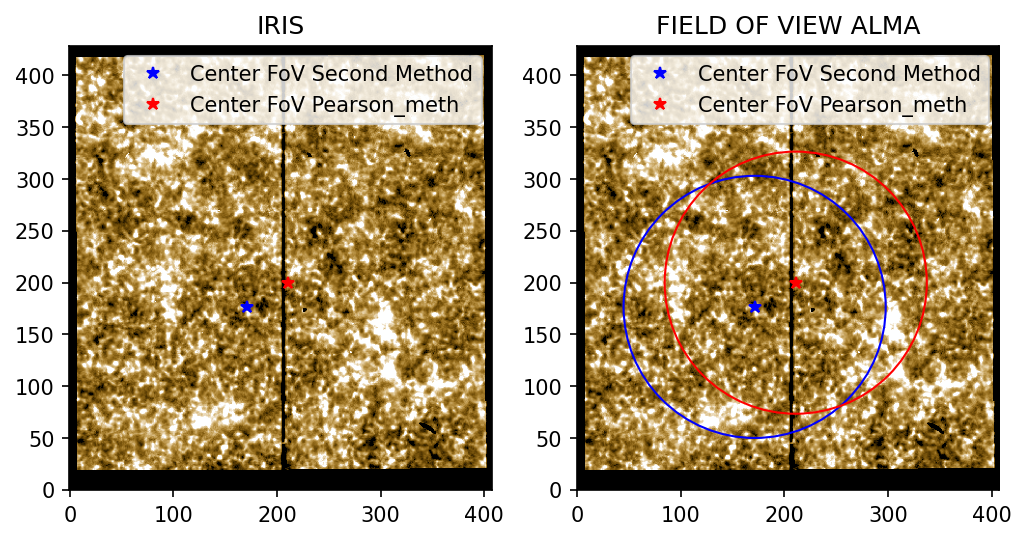

In [25]:
a= 266
b= 0
rescaling_iris_2796 = iris_rescale(iris_2796, 0.3)[a]
vmin_2796 = np.percentile(rescaling_iris_2796,11) 
vmax_2796 = np.percentile(rescaling_iris_2796,95) 

fig, ax=plt.subplots(1, 2, figsize=(8,8), dpi=150)
ax[0].set_title('IRIS')
ax[0].imshow(rescaling_iris_2796,origin='lower',cmap='irissji2796',vmin=vmin_2796,vmax=vmax_2796)
ax[0].plot(x_iris_center, y_iris_center,'b*', label='Center FoV Second Method')
ax[0].plot(211, 200,'r*', label='Center FoV Pearson_meth')
ax[0].legend()


ax[1].set_title('FIELD OF VIEW ALMA')
ax[1].imshow(rescaling_iris_2796,origin='lower',cmap='irissji2796',vmin=vmin_2796,vmax=vmax_2796)
ax[1].plot(x_iris_center, y_iris_center,'b*', label='Center FoV Second Method')
curculo=matplotlib.patches.Circle((x_iris_center, y_iris_center,'b*'),253/2,ec='blue', fc='none')
ax[1].add_patch(curculo)
ax[1].plot(211, 200,'r*',  label='Center FoV Pearson_meth')
curculo_2=matplotlib.patches.Circle((211, 200,'b*'),253/2,ec='red', fc='none')
ax[1].add_patch(curculo_2)
ax[1].legend()


## Comparing the two alignment methods, it is clearly evident that the **Pearson coefficient method** is better than the method where the displacements of the helioprojective coordinates are analyzed (**"second method"**).
## This is due to what was commented at the beginning of this method where it was commented that the IRIS headers ## are associated with a different UTC time than the ALMA headers.